# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [265]:
# import libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msn

from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,OneHotEncoder,PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor,plot_tree
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, RocCurveDisplay, roc_auc_score
from sklearn.metrics._scorer import _SCORERS


import category_encoders as ce
from category_encoders import BinaryEncoder

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

import warnings
warnings.filterwarnings('ignore')

In [180]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [182]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [183]:
# check data nullity, unique value
pd.set_option('display.max_colwidth', None)

pd.DataFrame({
    'feature':df.columns.values,
    'data_type':df.dtypes.values,
    'null':df.isna().mean().values * 100,
    'negative':[True if df[i].dtype == int and (df[i] < 0).any() else False for i in df.columns],
    'n_unique':df.nunique().values,
    'sample_unique':[df[i].unique() for i in df.columns]
})

,feature,data_type,null,negative,n_unique,sample_unique
0,num_passengers,int64,0.0,False,9,"[2, 1, 3, 4, 6, 5, 7, 9, 8]"
1,sales_channel,object,0.0,False,2,"[Internet, Mobile]"
2,trip_type,object,0.0,False,3,"[RoundTrip, CircleTrip, OneWay]"
3,purchase_lead,int64,0.0,False,470,"[262, 112, 243, 96, 68, 3, 201, 238, 80, 378, 185, 8, 265, 245, 192, 259, 19, 67, 351, 228, 21, 23, 25, 16, 66, 51, 37, 101, 7, 5, 33, 20, 56, 13, 71, 346, 9, 65, 221, 107, 14, 77, 24, 47, 22, 11, 35, 272, 250, 161, 128, 190, 311, 27, 314, 102, 2, 26, 32, 57, 198, 120, 69, 281, 282, 15, 31, 316, 232, 156, 196, 283, 34, 63, 6, 227, 181, 138, 134, 85, 93, 118, 90, 168, 127, 18, 153, 186, 263, 172, 230, 42, 81, 140, 285, 179, 341, 173, 180, 366, ...]"
4,length_of_stay,int64,0.0,False,335,"[19, 20, 22, 31, 48, 33, 30, 25, 43, 24, 17, 34, 18, 37, 29, 155, 88, 27, 21, 28, 47, 35, 82, 26, 90, 23, 84, 61, 40, 96, 69, 89, 58, 56, 110, 165, 111, 38, 207, 91, 1, 274, 44, 57, 106, 68, 87, 51, 196, 77, 41, 278, 108, 180, 72, 32, 62, 45, 50, 59, 125, 124, 46, 55, 60, 36, 65, 208, 204, 83, 42, 85, 64, 86, 54, 238, 275, 39, 95, 70, 93, 49, 107, 121, 203, 188, 78, 209, 126, 80, 200, 255, 63, 92, 118, 79, 181, 76, 94, 305, ...]"
5,flight_hour,int64,0.0,False,24,"[7, 3, 17, 4, 15, 20, 6, 14, 12, 2, 19, 10, 8, 23, 9, 13, 11, 0, 1, 5, 16, 18, 22, 21]"
6,flight_day,object,0.0,False,7,"[Sat, Wed, Thu, Mon, Sun, Tue, Fri]"
7,route,object,0.0,False,799,"[AKLDEL, AKLHGH, AKLHND, AKLICN, AKLKIX, AKLKTM, AKLKUL, AKLMRU, AKLPEK, AKLPVG, AKLTPE, AORICN, AORKIX, AORKTM, AORMEL, BBIMEL, BBIOOL, BBIPER, BBISYD, BDOCTS, BDOCTU, BDOHGH, BDOICN, BDOIKA, BDOKIX, BDOMEL, BDOOOL, BDOPEK, BDOPER, BDOPUS, BDOPVG, BDOSYD, BDOTPE, BDOXIY, BKICKG, BKICTS, BKICTU, BKIHND, BKIICN, BKIKIX, BKIKTM, BKIMEL, BKIMRU, BKIOOL, BKIPEK, BKIPER, BKIPUS, BKIPVG, BKISYD, BKIXIY, BLRICN, BLRMEL, BLRPER, BLRSYD, BOMMEL, BOMOOL, BOMPER, BOMSYD, BTJJED, BTUICN, BTUPER, BTUSYD, BTUWUH, BWNCKG, BWNDEL, BWNHGH, BWNIKA, BWNKTM, BWNMEL, BWNOOL, BWNPER, BWNSYD, BWNTPE, CANDEL, CANIKA, CANMEL, CANMRU, CANOOL, CANPER, CANSYD, CCUMEL, CCUMRU, CCUOOL, CCUPER, CCUSYD, CCUTPE, CEBMEL, CEBOOL, CEBPER, CEBSYD, CGKCKG, CGKCTS, CGKCTU, CGKDEL, CGKHGH, CGKHND, CGKICN, CGKIKA, CGKJED, CGKKIX, ...]"
8,booking_origin,object,0.0,False,104,"[New Zealand, India, United Kingdom, China, South Korea, Japan, Malaysia, Singapore, Switzerland, Germany, Indonesia, Czech Republic, Vietnam, Thailand, Spain, Romania, Ireland, Italy, Slovakia, United Arab Emirates, Tonga, Réunion, (not set), Saudi Arabia, Netherlands, Qatar, Hong Kong, Philippines, Sri Lanka, France, Croatia, United States, Laos, Hungary, Portugal, Cyprus, Australia, Cambodia, Poland, Belgium, Oman, Bangladesh, Kazakhstan, Brazil, Turkey, Kenya, Taiwan, Brunei, Chile, Bulgaria, Ukraine, Denmark, Colombia, Iran, Bahrain, Solomon Islands, Slovenia, Mauritius, Nepal, Russia, Kuwait, Mexico, Sweden, Austria, Lebanon, Jordan, Greece, Mongolia, Canada, Tanzania, Peru, Timor-Leste, Argentina, New Caledonia, Macau, Myanmar (Burma), Norway, Panama, Bhutan, Norfolk Island, Finland, Nicaragua, Maldives, Egypt, Israel, Tunisia, South Africa, Papua New Guinea, Paraguay, Estonia, Seychelles, Afghanistan, Guam, Czechia, Malta, Vanuatu, Belarus, Pakistan, Iraq, Ghana, ...]"
9,wants_extra_baggage,int64,0.0,False,2,"[1, 0]"


<Axes: >

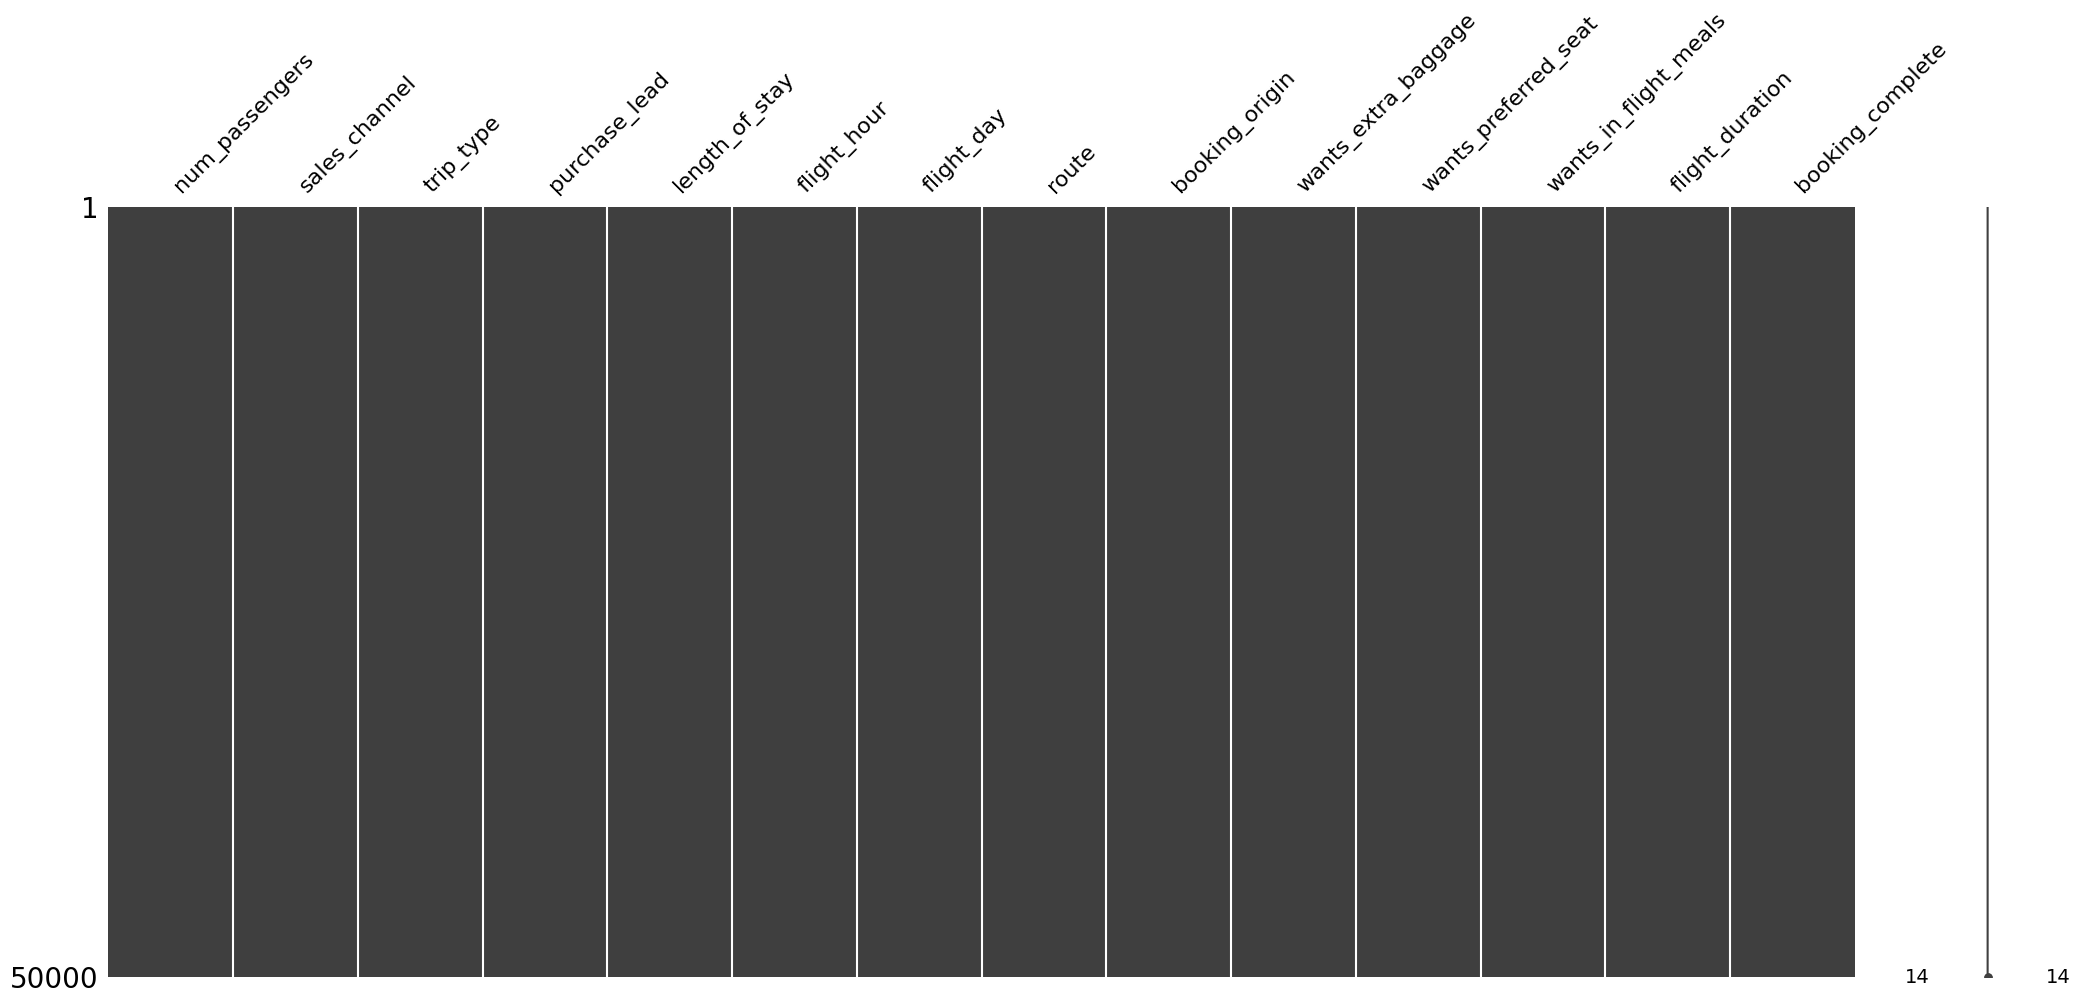

In [184]:
import missingno as msn

msn.matrix(df)

In [185]:
df.duplicated().sum()

719

In [186]:
df = df.drop_duplicates()

In [188]:
df["booking_complete"].value_counts(normalize=True)

booking_complete
0    0.850023
1    0.149977
Name: proportion, dtype: float64

In [189]:
def calculate_outliers(data, column):
    Q1 = data[column].quantile(.25)
    Q3 = data[column].quantile(.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

In [190]:
numerical_columns = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 
                     'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 
                     'flight_duration']

In [191]:
outlier_data = []

for i in numerical_columns:
    outliers_result, lower_bound, upper_bound = calculate_outliers(df, i)
    total_outlier = len(outliers_result)
    outlier_percentage = round(total_outlier/len(df[i])*100, 2)
    outlier_data.append([i, total_outlier, outlier_percentage, lower_bound, upper_bound])

outlier_df = pd.DataFrame(outlier_data, columns=["column", "total_outlier", "percentage", "lower_bound", "upper_bound"])
outlier_df

,column,total_outlier,percentage,lower_bound,upper_bound
0,num_passengers,2851,5.79,-0.500,3.500
1,purchase_lead,3391,6.88,-120.000,256.000
2,length_of_stay,3748,7.61,-29.500,62.500
3,flight_hour,0,0.00,-7.000,25.000
4,wants_extra_baggage,0,0.00,-1.500,2.500
5,wants_preferred_seat,0,0.00,-1.500,2.500
6,wants_in_flight_meals,0,0.00,-1.500,2.500
7,flight_duration,0,0.00,0.805,13.645


In [220]:
# Calculate outliers for each column and store the bounds
num_passengers_outliers, num_passengers_lower, num_passengers_upper = calculate_outliers(df, 'num_passengers')
purchase_lead_outliers, purchase_lead_lower, purchase_lead_upper = calculate_outliers(df, 'purchase_lead')
length_of_stay_outliers, length_of_stay_lower, length_of_stay_upper = calculate_outliers(df, 'length_of_stay')

In [221]:
df_no_outliers = df[
    (df["num_passengers"] >= num_passengers_lower) & (df["num_passengers"] <= num_passengers_upper) &
    (df["purchase_lead"] >= purchase_lead_lower) & (df["purchase_lead"] <= purchase_lead_upper) &
    (df["length_of_stay"] >= length_of_stay_lower) & (df["length_of_stay"] <= length_of_stay_upper)
]

In [222]:
# Check the result
print(f"Original dataframe size: {df.shape}")
print(f"Dataframe size after removing outliers: {df_no_outliers.shape}")

Original dataframe size: (49281, 14)
Dataframe size after removing outliers: (39902, 14)


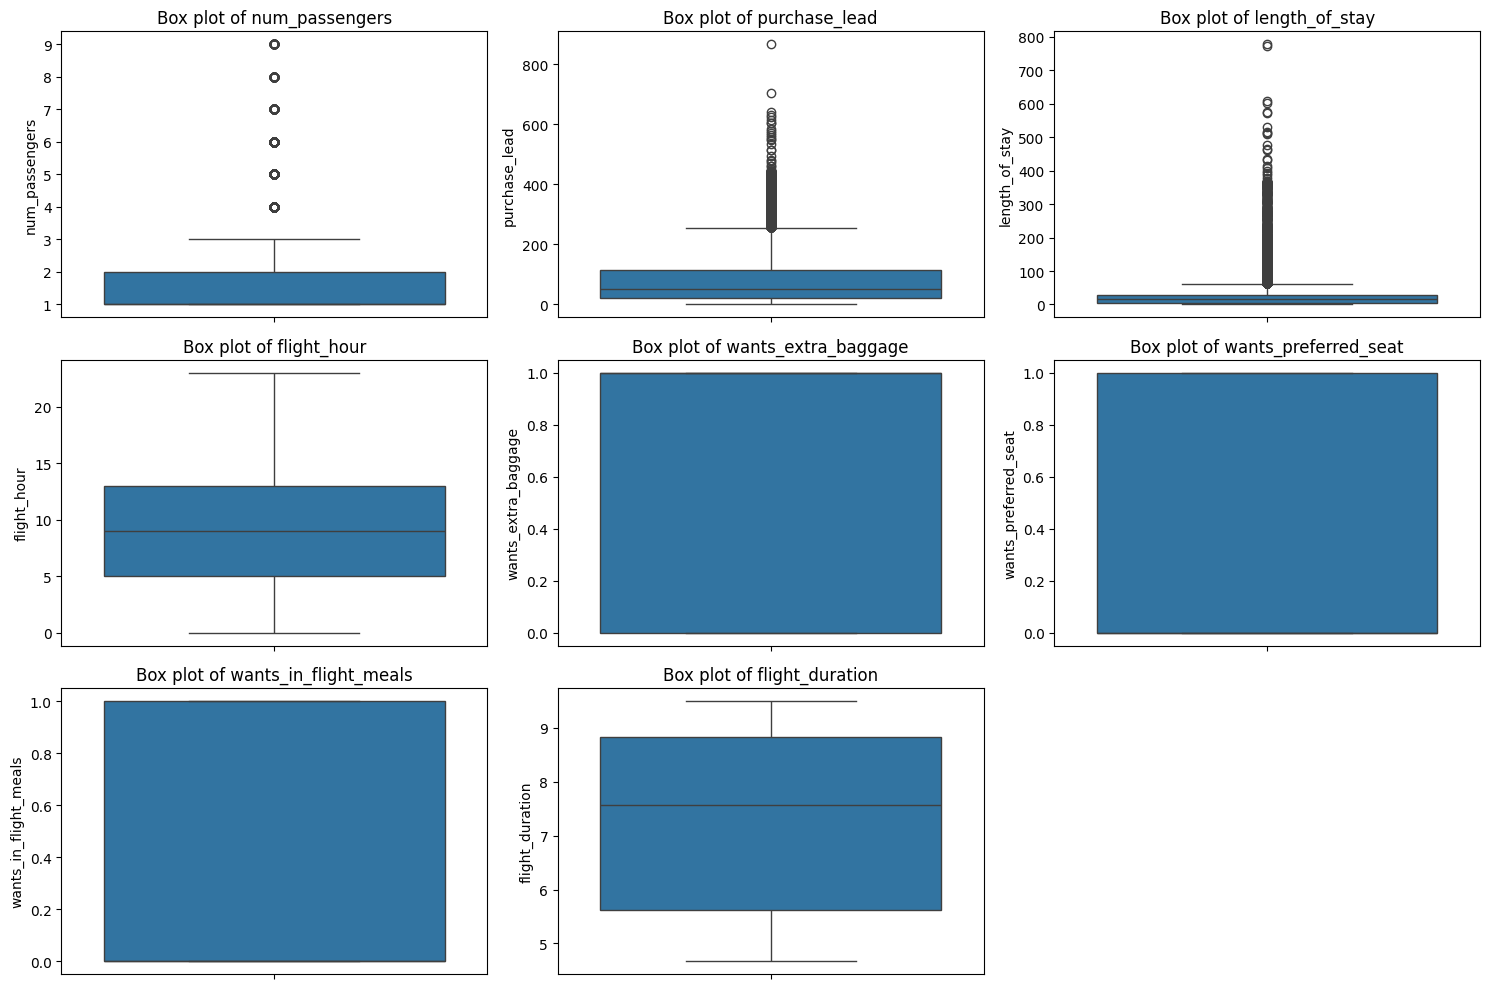

In [104]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Create box plots for each numerical column
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df[column])
    plt.title(f'Box plot of {column}')

plt.tight_layout()
plt.show()


> Preprocess and Feature Engineering


In [223]:
X = df_no_outliers.drop("booking_complete", axis = 1)
y = df_no_outliers["booking_complete"]

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,y,
    test_size=0.2,
    stratify = y,
    random_state=14
)
X_train_val.shape, X_test.shape

((31921, 13), (7981, 13))

In [224]:
X

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52
5,1,Internet,RoundTrip,3,48,20,Thu,AKLDEL,New Zealand,1,0,1,5.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,Sat,PERPNH,Australia,1,0,1,5.62
49996,1,Internet,RoundTrip,111,6,4,Sun,PERPNH,Australia,0,0,0,5.62
49997,1,Internet,RoundTrip,24,6,22,Sat,PERPNH,Australia,0,0,1,5.62
49998,1,Internet,RoundTrip,15,6,11,Mon,PERPNH,Australia,1,0,1,5.62


In [225]:
transformer = ColumnTransformer([
    ("onehot", OneHotEncoder(drop="first"), ["sales_channel", "trip_type", "flight_day"]),
    ("binary", BinaryEncoder(), ["route", "booking_origin"]),
    ("scaler", RobustScaler(), ["num_passengers", "purchase_lead", "length_of_stay", "flight_duration"])
], remainder="passthrough")

#scaler = RobustScaler()

In [226]:
# Data transformation
X_train_preprocess = transformer.fit_transform(X_train_val)
X_test_preprocess = transformer.transform(X_test)

In [227]:
X_train_preprocess = pd.DataFrame(X_train_preprocess)
X_train_preprocess

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,0.053333,-0.10,-0.903427,6.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,-0.413333,0.65,0.392523,5.0,1.0,1.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.626667,1.30,0.392523,12.0,1.0,0.0,1.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,-0.133333,0.00,0.314642,6.0,1.0,0.0,1.0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,-0.546667,-0.20,0.392523,9.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31916,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.333333,-0.05,0.392523,11.0,0.0,0.0,0.0
31917,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.800000,0.80,-0.607477,8.0,1.0,0.0,0.0
31918,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.320000,1.30,0.392523,0.0,1.0,1.0,0.0
31919,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,-0.226667,-0.05,-0.607477,6.0,1.0,0.0,1.0


In [228]:
X_test_preprocess = pd.DataFrame(X_test_preprocess)
X_test_preprocess

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.493333,-0.15,-0.177570,3.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.266667,1.10,0.314642,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,-0.586667,-0.10,-0.607477,3.0,1.0,1.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.080000,1.85,-0.607477,15.0,1.0,1.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.213333,0.85,-0.358255,14.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7976,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.613333,1.85,0.392523,11.0,1.0,0.0,0.0
7977,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.280000,-0.10,-0.295950,11.0,1.0,1.0,1.0
7978,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.346667,0.75,0.392523,3.0,0.0,0.0,1.0
7979,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.293333,0.80,0.314642,6.0,1.0,1.0,1.0


In [229]:
# Getting the column name back
transformer.transformers_

[('onehot',
  OneHotEncoder(drop='first'),
  ['sales_channel', 'trip_type', 'flight_day']),
 ('binary',
  BinaryEncoder(cols=['route', 'booking_origin'],
                mapping=[{'col': 'route',
                          'mapping':       route_0  route_1  route_2  route_3  route_4  route_5  route_6  route_7  \
   1          0        0        0        0        0        0        0        0   
   2          0        0        0        0        0        0        0        0   
   3          0        0        0        0        0        0        0        0   
   4          0        0        0        0        0        0        0        1   
   5          0        0        0        0        0        0        0        1   
  ...       ...      ...      ...      ...      ...      ...      ...      ...   
   771        1        1        0        0        0        0        0        0   
   772        1        1        0        0        0        0        0        1   
   773        1        1       

In [230]:
feature_names = transformer.transformers_[0][1].get_feature_names_out()
feature_names

array(['sales_channel_Mobile', 'trip_type_OneWay', 'trip_type_RoundTrip',
       'flight_day_Mon', 'flight_day_Sat', 'flight_day_Sun',
       'flight_day_Thu', 'flight_day_Tue', 'flight_day_Wed'], dtype=object)

In [231]:
feature_names2 = transformer.transformers_[1][1].get_feature_names_out()
feature_names2

array(['route_0', 'route_1', 'route_2', 'route_3', 'route_4', 'route_5',
       'route_6', 'route_7', 'route_8', 'route_9', 'booking_origin_0',
       'booking_origin_1', 'booking_origin_2', 'booking_origin_3',
       'booking_origin_4', 'booking_origin_5', 'booking_origin_6'],
      dtype=object)

In [232]:
features = list(feature_names) + list(feature_names2) + ["num_passengers", "purchase_lead", "length_of_stay", "flight_hour", "wants_extra_baggage", "wants_preferred_seat", "wants_in_flight_meals", "flight_duration"]
X_train_preprocess.columns = features
X_test_preprocess.columns = features
display(X_train_preprocess, X_test_preprocess)

,sales_channel_Mobile,trip_type_OneWay,trip_type_RoundTrip,flight_day_Mon,flight_day_Sat,flight_day_Sun,flight_day_Thu,flight_day_Tue,flight_day_Wed,route_0,...,booking_origin_5,booking_origin_6,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,0.053333,-0.10,-0.903427,6.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,-0.413333,0.65,0.392523,5.0,1.0,1.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.626667,1.30,0.392523,12.0,1.0,0.0,1.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,-0.133333,0.00,0.314642,6.0,1.0,0.0,1.0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,-0.546667,-0.20,0.392523,9.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31916,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.333333,-0.05,0.392523,11.0,0.0,0.0,0.0
31917,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.800000,0.80,-0.607477,8.0,1.0,0.0,0.0
31918,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.320000,1.30,0.392523,0.0,1.0,1.0,0.0
31919,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,-0.226667,-0.05,-0.607477,6.0,1.0,0.0,1.0


,sales_channel_Mobile,trip_type_OneWay,trip_type_RoundTrip,flight_day_Mon,flight_day_Sat,flight_day_Sun,flight_day_Thu,flight_day_Tue,flight_day_Wed,route_0,...,booking_origin_5,booking_origin_6,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.493333,-0.15,-0.177570,3.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.266667,1.10,0.314642,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,-0.586667,-0.10,-0.607477,3.0,1.0,1.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.080000,1.85,-0.607477,15.0,1.0,1.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.213333,0.85,-0.358255,14.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7976,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.613333,1.85,0.392523,11.0,1.0,0.0,0.0
7977,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.280000,-0.10,-0.295950,11.0,1.0,1.0,1.0
7978,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.346667,0.75,0.392523,3.0,0.0,0.0,1.0
7979,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.293333,0.80,0.314642,6.0,1.0,1.0,1.0


> Metric Evaluation

Since we want to predict whether a customer booked a flight or not and we have an imbalance data, we will use F1-score to evaluate the model.

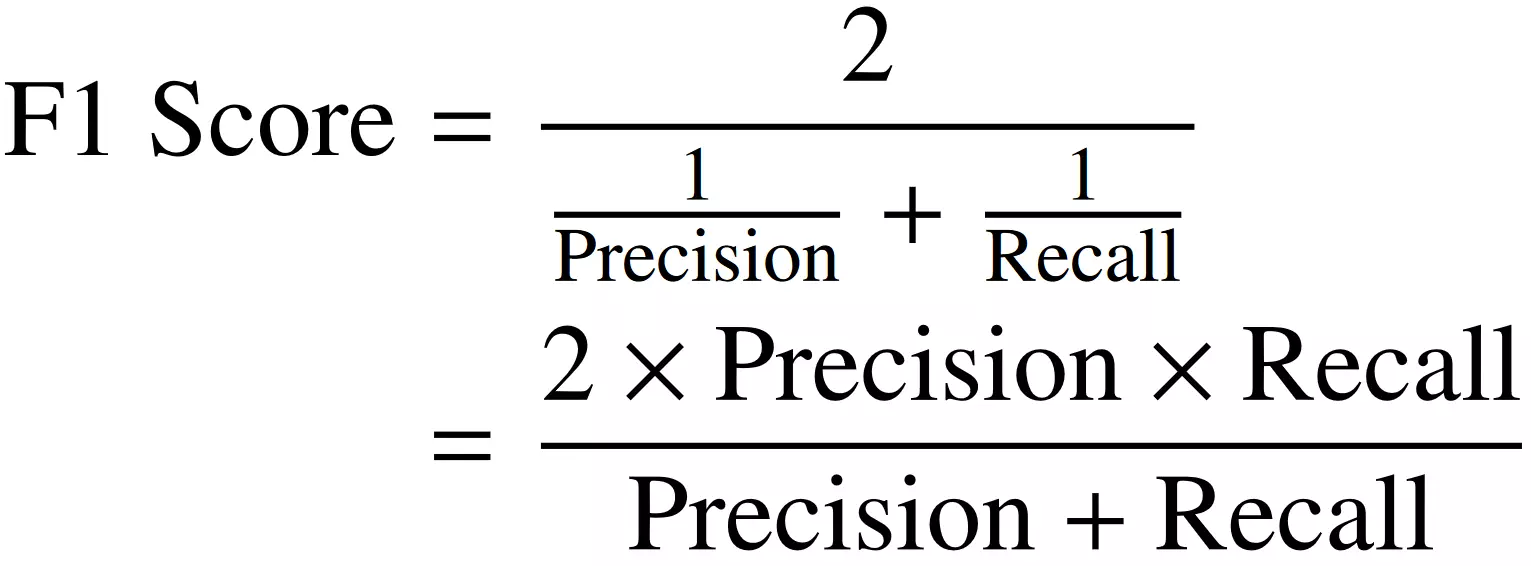

> Modeling

In [233]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()
xgboost = XGBClassifier()

In [235]:
# Train the data and do some oversampling with SMOTE

models = [logreg, knn, dtree, rf, gboost, xgboost]
score = []
nilai_mean = []
nilai_std = []

smote = SMOTE()

for i in models:

    model_pipeline = ImbPipeline([
        ("balancing", smote),
        ("modeling", i)
    ])

    skfold = StratifiedKFold(n_splits=10)

    model_cv = cross_val_score(
        model_pipeline, 
        X_train_preprocess, 
        y_train_val, 
        cv=skfold, 
        scoring='f1', 
        error_score='raise'
        )

    print(model_cv, i)

    score.append(model_cv)
    nilai_mean.append(model_cv.mean())
    nilai_std.append(model_cv.std())


[0.3703271  0.36684948 0.36363636 0.38588235 0.36213018 0.36643026
 0.37957958 0.37010247 0.36162791 0.37733645] LogisticRegression()
[0.34275618 0.35405565 0.36460177 0.36298932 0.34736842 0.35978836
 0.35990621 0.346651   0.35205559 0.35259778] KNeighborsClassifier()
[0.32906404 0.28318584 0.30972616 0.2728146  0.31548757 0.31
 0.27203065 0.29146692 0.28409091 0.2821256 ] DecisionTreeClassifier()
[0.23157895 0.24813154 0.21492537 0.26587888 0.25797101 0.27153285
 0.26268657 0.30042918 0.28368794 0.27192982] RandomForestClassifier()
[0.25925926 0.30645161 0.28571429 0.27651007 0.2764457  0.2983871
 0.28169014 0.3125     0.30393487 0.32085561] GradientBoostingClassifier()
[0.18269231 0.25194401 0.24732824 0.21638331 0.21528861 0.24577573
 0.20985692 0.26646707 0.23861852 0.22503962] XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
      

In [236]:
train_score = pd.DataFrame({
    'model':['Logistic Regression', 'Knn', 'Decision Tree', 'Random Forrest', 'Gradient Boost', 'XG Boost'],
    'mean':nilai_mean,
    'std':nilai_std
}).sort_values(by='mean',ascending=False)
train_score

,model,mean,std
0,Logistic Regression,0.370390,0.007692
1,Knn,0.354277,0.007007
2,Decision Tree,0.294999,0.018651
4,Gradient Boost,0.292175,0.018287
3,Random Forrest,0.260875,0.023430
5,XG Boost,0.229939,0.023463


In [237]:
test_predict = []

for model in models:
    model.fit(X_train_preprocess, y_train_val)
    y_pred = model.predict(X_test_preprocess)
    f1_result = f1_score(y_test, y_pred)
    test_predict.append(f1_result)

pd.concat([train_score, pd.DataFrame(test_predict, columns=['test predict'])],axis=1)

,model,mean,std,test predict
0,Logistic Regression,0.370390,0.007692,0.032415
1,Knn,0.354277,0.007007,0.191716
2,Decision Tree,0.294999,0.018651,0.277647
4,Gradient Boost,0.292175,0.018287,0.058637
3,Random Forrest,0.260875,0.023430,0.170833
5,XG Boost,0.229939,0.023463,0.205029


> Hyperparameter Tuning

In [238]:
# Decision Tree

model = DecisionTreeClassifier()
score = []
nilai_mean = []
nilai_std = []

smote = SMOTE()
# poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

model_pipeline = ImbPipeline([
    # ("poly", poly),
    ("balancing", smote),
    ("modeling", model)
])

param_dist = {
    'modeling__criterion': ['gini', 'entropy'],
    'modeling__splitter': ['best', 'random'],
    'modeling__max_depth': [None, 10, 20, 30, 40, 50],
    'modeling__min_samples_split': [2, 5, 10, 20],
    'modeling__min_samples_leaf': [1, 2, 5, 10],
    #'modeling__max_features': [None, 'auto', 'sqrt', 'log2'],
    'modeling__class_weight': [None, 'balanced'],
}

skfold = StratifiedKFold(n_splits=10)

random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_dist,
    scoring='f1',
    cv=skfold,
    n_jobs=-1,
    verbose=1,
    error_score='raise' 
)

In [239]:
random_search.fit(X_train_preprocess, y_train_val)

# Print the best parameters and best score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best F1 Score: {random_search.best_score_}")

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters: {'modeling__splitter': 'random', 'modeling__min_samples_split': 10, 'modeling__min_samples_leaf': 1, 'modeling__max_depth': 10, 'modeling__criterion': 'gini', 'modeling__class_weight': None}
Best F1 Score: 0.41134340175952355


In [240]:
# Predict
y_pred =random_search.best_estimator_.predict(X_test_preprocess)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.81      0.86      6790
           1       0.32      0.50      0.39      1191

    accuracy                           0.77      7981
   macro avg       0.61      0.66      0.62      7981
weighted avg       0.82      0.77      0.79      7981



In [255]:
# Logistic Regression

model = LogisticRegression(C=0.1, max_iter=500)
score = []
nilai_mean = []
nilai_std = []

smote = SMOTE()
# poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

model_pipeline = ImbPipeline([
    # ("poly", poly),
    ("balancing", smote),
    ("modeling", model)
])

param_dist = {
    # 'modeling__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'modeling__solver': ['newton-cg', 'liblinear']  # Solver
    # 'modeling__max_iter': [100, 200, 300, 500]  # Maximum iterations
}

skfold = StratifiedKFold(n_splits=5)

random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_dist,
    scoring='f1',
    cv=skfold,
    n_jobs=-1,
    verbose=1,
    error_score='raise' 
)

In [256]:
random_search.fit(X_train_preprocess, y_train_val)

# Print the best parameters and best score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best F1 Score: {random_search.best_score_}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'modeling__solver': 'liblinear'}
Best F1 Score: 0.37154011728512376


In [243]:
# Predict
y_pred =random_search.best_estimator_.predict(X_test_preprocess)
print(classification_report(y_test,y_pred))

In [257]:
# Random Forest

model = RandomForestClassifier()
score = []
nilai_mean = []
nilai_std = []

smote = SMOTE()
# poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

model_pipeline = ImbPipeline([
    # ("poly", poly),
    ("balancing", smote),
    ("modeling", model)
])

param_dist = {
    'modeling__n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    # 'modeling__max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at every split
    'modeling__max_depth': [None, 10, 20, 30, 40, 50],  # Maximum number of levels in tree
    'modeling__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'modeling__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
    # 'modeling__bootstrap': [True, False]  # Method of selecting samples for training each tree
}

skfold = StratifiedKFold(n_splits=5)

random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_dist,
    scoring='f1',
    cv=skfold,
    n_jobs=-1,
    verbose=2,
    error_score='raise' 
)

In [258]:
random_search.fit(X_train_preprocess, y_train_val)

# Print the best parameters and best score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best F1 Score: {random_search.best_score_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'modeling__n_estimators': 500, 'modeling__min_samples_split': 5, 'modeling__min_samples_leaf': 4, 'modeling__max_depth': 20}
Best F1 Score: 0.3316833752720345


In [259]:
# Predict
y_pred =random_search.best_estimator_.predict(X_test_preprocess)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6790
           1       0.41      0.28      0.33      1191

    accuracy                           0.83      7981
   macro avg       0.64      0.61      0.62      7981
weighted avg       0.81      0.83      0.82      7981



In [276]:
# XG Boost

xgb = XGBClassifier()
score = []
nilai_mean = []
nilai_std = []

smote = SMOTE()

model_pipeline = ImbPipeline([
    ("balancing", smote),
    ("modeling", xgb)
])

param_dist = {
    'modeling__n_estimators': [100, 200, 300],  # Number of boosting rounds
    'modeling__learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
    'modeling__max_depth': [3, 5, 7, 9],  # Maximum tree depth
    'modeling__min_child_weight': [1, 3, 5],  # Minimum sum of instance weight needed in a child
    'modeling__subsample': [0.6, 0.8, 1.0],  # Subsample ratio of the training instances
    'modeling__colsample_bytree': [0.6, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree
    'modeling__gamma': [0, 0.1, 0.2, 0.3],  # Minimum loss reduction required to make a further partition on a leaf node
    'modeling__reg_alpha': [0, 0.1, 0.5, 1.0],  # L1 regularization term on weights
    'modeling__reg_lambda': [0.1, 1.0, 10.0],  # L2 regularization term on weights
    'modeling__scale_pos_weight': [1, 3, 5]  # Balancing the positive and negative weights
}

skfold = StratifiedKFold(n_splits=5)

random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_dist,
    scoring='f1',
    cv=skfold,
    n_jobs=-1,
    verbose=1,
    error_score='raise' 
)

In [277]:
random_search.fit(X_train_preprocess, y_train_val)

# Print the best parameters and best score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best F1 Score: {random_search.best_score_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'modeling__subsample': 0.6, 'modeling__scale_pos_weight': 5, 'modeling__reg_lambda': 0.1, 'modeling__reg_alpha': 1.0, 'modeling__n_estimators': 300, 'modeling__min_child_weight': 3, 'modeling__max_depth': 7, 'modeling__learning_rate': 0.05, 'modeling__gamma': 0.1, 'modeling__colsample_bytree': 0.8}
Best F1 Score: 0.4322379282525211


In [279]:
# Predict
y_pred =random_search.best_estimator_.predict(X_test_preprocess)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.76      0.84      6790
           1       0.32      0.63      0.43      1191

    accuracy                           0.74      7981
   macro avg       0.62      0.70      0.63      7981
weighted avg       0.83      0.74      0.77      7981



In [280]:
confusion_matrix(y_test, y_pred)

array([[5188, 1602],
       [ 437,  754]], dtype=int64)

In [281]:
roc_auc_score(y_test, y_pred)

0.6985731226713854

                  Feature  Importance
24       booking_origin_5    0.141187
25       booking_origin_6    0.066943
23       booking_origin_4    0.048204
21       booking_origin_2    0.042196
0    sales_channel_Mobile    0.041952
22       booking_origin_3    0.037034
29            flight_hour    0.030299
31   wants_preferred_seat    0.029719
9                 route_0    0.027944
2     trip_type_RoundTrip    0.025834
16                route_7    0.024842
20       booking_origin_1    0.023959
10                route_1    0.023746
1        trip_type_OneWay    0.023585
28         length_of_stay    0.023175
17                route_8    0.023136
12                route_3    0.022951
32  wants_in_flight_meals    0.022750
14                route_5    0.022718
15                route_6    0.022326
11                route_2    0.022187
13                route_4    0.021769
33        flight_duration    0.021392
27          purchase_lead    0.021005
18                route_9    0.020937
4          f

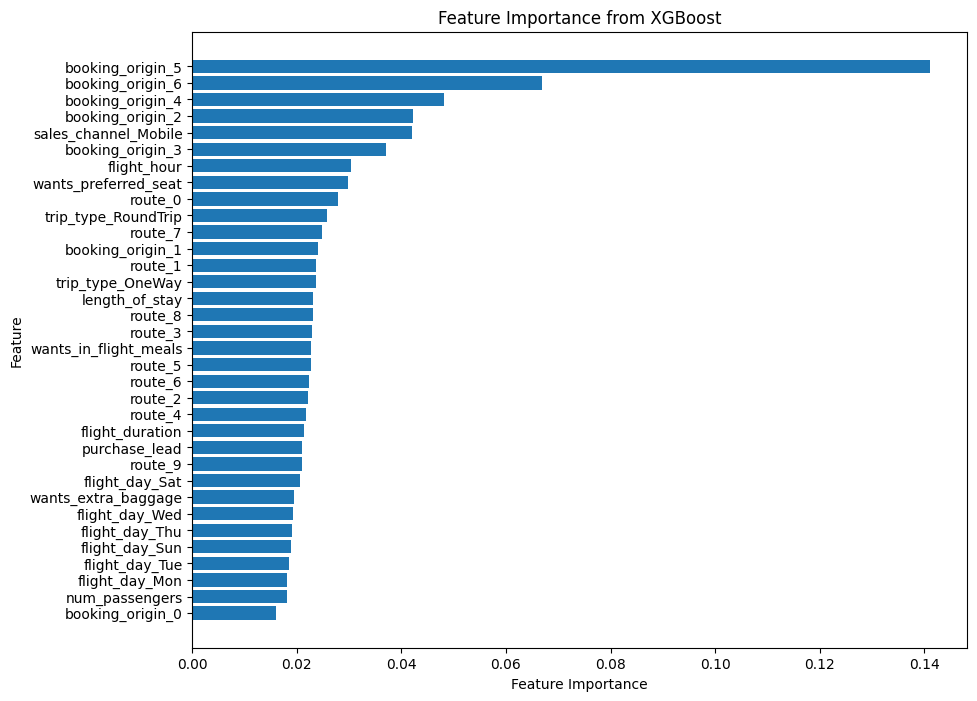

In [283]:
# Get the best model from the random search
best_model = random_search.best_estimator_.named_steps['modeling']

# Fit the best model on the training data
best_model.fit(X_train_preprocess, y_train_val)

# Get feature names after preprocessing (assuming you have a transformer)
feature_names = X_train_preprocess.columns.tolist()

# Get feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from XGBoost')
plt.gca().invert_yaxis()
plt.show()